# TreeCorr Explorer 2 #
In the last notebook, we explored the basic syntax of TreeCorr and made some plots. In this notebook, we aspire to make more informed plot by:
1. Applying mask ```df['imag_cmodel'] < 23``` and separate data into photo-z bins from 0.2-0.4, 0.4-0.6, 0.6-0.8;
2. Verify the cause of the warning when using the ```rand``` catalog;
3. Explore possible scalar-scalar correlation.

In [1]:
from __future__ import print_function
from astropy.io import fits
import numpy as np
import pandas as pd
import treecorr
import time
import pprint
import matplotlib
from matplotlib import pyplot as plt
from astropy.table import Table
%matplotlib inline

In [2]:
plt.rcdefaults()
plt.rcParams.update({'figure.dpi':100})
plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })
plt.rc('legend',**{'fontsize':'x-small'})
#plt.figure(1,figsize = [11.0, 8.5])
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':'True'})
plt.rcParams.update({'ytick.right':'True'})
plt.rcParams.update({'axes.formatter.limits': (-2, 2)})
# My own adds to Carles' rcParams updates
#plt.rcParams.update({'lines.markersize': 8}) 6 is the default
plt.rcParams.update({'legend.framealpha': 1.0})
plt.rcParams.update({'legend.fancybox': 'False'})

## Defined functions ##

In [43]:
# colorwheel = ['salmon', 'red', 'orange', 'yellow', 'yellowgreen', 'green', 'teal', 'cyan', 'blue', 'purple']

In [3]:
def label_generator(r):
    '''Given a list or array r, returns range labels in the form of list.'''
    labels = []
    s = '{:0.1f}-{:0.1f}'
    for i in range(len(r)-1):
        if (i == len(r)-2):
            labels.append('{}-'.format(r[i]))
        else:
            labels.append(s.format(r[i], r[i+1]))
    return labels

# pz_labels = label_generator(np.arange(0, 8, 0.2))
# mag_labels = label_generator(np.arange(17, 25, 1))

^ The range of labels is not the same as the range one will define in binning, beware.

In [4]:
gg = treecorr.GGCorrelation(min_sep=1, max_sep=400, 
                            nbins=15, sep_units='arcmin', var_method='jackknife')

In [5]:
dd = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [6]:
rr = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [7]:
dr = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

Jacknifing hasn't worked for me, look up patches.

In [8]:
ng = treecorr.NGCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [9]:
def plot_gg(data, labels, figsize):
    ''' Takes in galaxy data and pz_labels to plot shear-shear correlation.
    data: pd dataframe
    labels: list
    figsize: list of two length elements
    '''
    figs, axes = plt.subplots(len(labels), 1, sharex=True, figsize = figsize)
    for i in range(len(labels)):
        mask = data.pz_group == labels[i]
        ra = data[mask].ira
        dec = data[mask].idec
        g1 = data[mask].ishape_hsm_regauss_e1
        g2 = data[mask].ishape_hsm_regauss_e2
        cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, npatch=10,
                              ra_units='degrees', dec_units='degrees')
        gg.process(cat)
        r = np.exp(gg.meanlogr)
        xip = gg.xip
        xim = gg.xim
        sig = np.sqrt(gg.varxip)
        
        axes[i].plot(r, xip, color='blue')
        axes[i].plot(r, -xip, color='blue', ls=':')
        axes[i].errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], color='blue', lw=0.1, ls='')
        axes[i].errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], color='blue', lw=0.1, ls='')
        lp = axes[i].errorbar(-r, xip, yerr=sig, color='blue')
        
        axes[i].plot(r, xim, color='green')
        axes[i].plot(r, -xim, color='green', ls=':')
        axes[i].errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
        axes[i].errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
        lm = axes[i].errorbar(-r, xim, yerr=sig, color='green')
        
        axes[i].set_xscale('log')
        axes[i].set_yscale('log', nonposy='clip')
        if (i == len(labels)-1):
            axes[i].set_xlabel(r'$\theta$ (arcmin)')
        axes[i].set_title('z={}'.format(labels[i]))
        axes[i].legend([lp, lm], [r'$\xi_+(\theta)$', r'$\xi_-(\theta)$'])
        axes[i].set_xlim( [1,200] )
        axes[i].set_ylabel(r'$\xi_{+,-}$')
        
    plt.show()

In [10]:
def plot_ng(data, labels, figsize):
    ''' 
    ng correlation needs a source and lens catalog of which 
    z_source > z_lens. Function returns a plot of gamma_t for the 
    respective lens and source bins.
    data: pd dataframe
    labels: list
    figsize: list of two length elements
    '''
    # Find out how to add a set of master axes for source and lens z
    n = len(labels)
    figs, axes = plt.subplots(n, n, sharex=False, figsize = figsize)
    # i iterate through z_source, row data
    # j iterate through z_lens, col data
    # Make sure that i and j iterate through the same things
    for i in range(n):
        smask = data.pz_group == labels[i]
        sra = data[smask].ira
        sdec = data[smask].idec
        sg1 = data[smask].ishape_hsm_regauss_e1
        sg2 = data[smask].ishape_hsm_regauss_e2
        sw = data[smask].ishape_hsm_regauss_derived_shape_weight
        scat = treecorr.Catalog(ra=sra, dec=sdec, g1=sg1, g2=sg2, w=sw, npatch=40, 
                                        ra_units='degrees', dec_units='degrees')
        for j in range(n):
            if (i > j):
                lmask = data.pz_group == labels[j]
                lra = data[lmask].ira
                ldec = data[lmask].idec
                lg1 = data[lmask].ishape_hsm_regauss_e1
                lg2 = data[lmask].ishape_hsm_regauss_e2
                lw = data[lmask].ishape_hsm_regauss_derived_shape_weight
                lcat = treecorr.Catalog(ra=lra, dec=ldec, g1=lg1, g2=lg2, w=lw, npatch=40,
                                        ra_units='degrees', dec_units='degrees')

                ng.process(lcat, scat)
                r = np.exp(ng.meanlogr)
                xip = ng.xi
                xim = ng.xi_im
                sig = np.sqrt(ng.varxi)

                axes[i, j].scatter(r, xip, color='blue')
                axes[i, j].scatter(r, -xip, color='lightblue', ls=':')
                axes[i, j].errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], 
                                    color='blue', lw=0.1, ls='')
                axes[i, j].errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], 
                                    color='blue', lw=0.1, ls='')
                lp = axes[i, j].errorbar(-r, xip, yerr=sig, color='blue')

                #axes[i, j].plot(r, xim, color='green')
                #axes[i, j].plot(r, -xim, color='green', ls=':')
                #axes[i, j].errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
                #axes[i, j].errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
                #lm = axes[i, j].errorbar(-r, xim, yerr=sig, color='green')
        
                axes[i, j].set_xscale('log')
                axes[i, j].set_yscale('log', nonposy='clip')
                #if (i == len(labels)-1):
                #    axes[i].set_xlabel(r'$\theta$ (arcmin)')
                axes[i, j].set_title(r'$z_s:{}$, $z_l:{}$'.format(labels[i], labels[j]))
                axes[i, j].legend([lp], [r'$\xi_{Re}(\theta)$'])
                axes[i, j].set_xlim( [1, 50] )
                axes[i, j].set_xlabel(r'$\theta$ (arcmin)')
                axes[i, j].set_ylabel(r'$\xi_{Re}$')
            else:
                axes[i, j].set_axis_off()
        
    plt.show()

In [11]:
def plot_dr(data, random, labels, figsize, param):
    ''' Takes in galaxy data, random catalog and pz_labels to plot data-random correlation.
    data: pd dataframe
    random: pd dataframe
    labels: list
    figsize: list of two length elements
    param: str object that is either 'pz' or 'mag'
    '''
    figs, axes = plt.subplots(1, 1, sharex=True, figsize = figsize)
    for i in range(len(labels)):
        if (param == 'pz'):
            mask = data.pz_group == labels[i]
        elif (param == 'mag'):
            mask = data.mag_group == labels[i]
        
        cra = data[mask].ira
        cdec = data[mask].idec
        cg1 = data[mask].ishape_hsm_regauss_e1
        cg2 = data[mask].ishape_hsm_regauss_e2
        cw = data[mask].ishape_hsm_regauss_derived_shape_weight        
        cat = treecorr.Catalog(ra=cra, dec=cdec, g1=cg1, g2=cg2, w=cw, npatch=10,
                              ra_units='degrees', dec_units='degrees')
        
        rra = random.ra
        rdec = random.dec       
        rand = treecorr.Catalog(ra=rra, dec=rdec, npatch=10, 
                                ra_units='degrees', dec_units='degrees')
        
        dd.process(cat)
        rr.process(rand)
        dr.process(cat, rand)
        xi, varxi = dd.calculateXi(rr, dr)
        r = np.exp(dd.meanlogr)
        sig = np.sqrt(varxi)
        
        axes.plot(r, xi, color=colorwheel[i], label='{}:{}'.format(param, labels[i]))
        axes.plot(r, -xi, color=colorwheel[i], ls=':')
        axes.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes.errorbar(-r, xi, yerr=sig, color='blue')
        
    axes.set_title('Clustering in {} bins'.format(param))    
    axes.set_xscale('log')
    axes.set_yscale('log', nonposy='clip')
    axes.set_xlabel(r'$\theta$ (arcmin)')
    axes.legend()
        
    plt.show()

In [67]:
def plot_dr_separate(data, random, labels, figsize, param):
    ''' Takes in galaxy data, random catalog and pz_labels to plot data-random correlation.
    data: pd dataframe
    random: pd dataframe
    labels: list
    figsize: list of two length elements
    param: str object that is either 'pz' or 'mag'
    '''
    figs, axes = plt.subplots(len(labels), 1, sharex=True, figsize = figsize)
    for i in range(len(labels)):
        if (param == 'pz'):
            mask = data.pz_group == labels[i]
        elif (param == 'mag'):
            mask = data.mag_group == labels[i]
        
        cra = data[mask].ira
        cdec = data[mask].idec
        cg1 = data[mask].ishape_hsm_regauss_e1
        cg2 = data[mask].ishape_hsm_regauss_e2
        cw = data[mask].ishape_hsm_regauss_derived_shape_weight        
        cat = treecorr.Catalog(ra=cra, dec=cdec, g1=cg1, g2=cg2, w=cw, npatch=10,
                              ra_units='degrees', dec_units='degrees')
        
        rra = random.ra
        rdec = random.dec       
        rand = treecorr.Catalog(ra=rra, dec=rdec, npatch=10, 
                                ra_units='degrees', dec_units='degrees')
        
        dd.process(cat)
        rr.process(rand)
        dr.process(cat, rand)
        xi, varxi = dd.calculateXi(rr, dr)
        r = np.exp(dd.meanlogr)
        sig = np.sqrt(varxi)
        
        axes[i].plot(r, xi, color='blue')
        axes[i].plot(r, -xi, color='blue', ls=':')
        axes[i].errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
        axes[i].errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
        leg = plt.errorbar(-r, xi, yerr=sig, color='blue')
        
        
        axes[i].set_xscale('log')
        axes[i].set_yscale('log', nonposy='clip')
        axes[i].set_xlabel(r'$\theta$ (arcmin)')
        if param == 'pz':
            axes[i].set_title('z:{}'.format(labels[i]))
        elif param == 'mag':
            axes[i].set_title('imag:{}'.format(labels[i]))
        axes[i].legend([leg], [r'$w(\theta)$'], loc='upper right')
        axes[i].set_xlim([0.01,10])
        
    plt.show()

## Mask the HECTOMAP catalogs ##

### Import data ###

In [12]:
hectomap_path = "Data/HECTOMAP_calibrated.fits"
hectomap_pz_path = "Data/HECTOMAP_pz.fits"
hectomap_rand_path = "Data/HECTOMAP_rand.fits"

In [13]:
df = Table.read(hectomap_path, format='fits').to_pandas()
pz_df = Table.read(hectomap_pz_path, format='fits').to_pandas()
rand_df = Table.read(hectomap_rand_path, format='fits').to_pandas()

### Separate into pz bins and imag bins ###

In [14]:
pz_range = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, 100])
pz_labels = label_generator(pz_range)

In [ ]:
mag_range = np.array([])

In [15]:
colorwheel = ['blue', 'red', 'green', 'orange', 'teal', 'purple', 'cyan']

In [16]:
df['pz_group'] = pd.cut(pz_df.ephor_photoz_best, pz_range, right=False, labels=pz_labels)

In [17]:
df['mag_group'] = pd.cut(df.imag_cmodel, np.arange(17, 26, 1), right=False, labels=mag_labels)

NameError: name 'mag_labels' is not defined

### Enforce i-band magnitude cut ###

In [17]:
imag_mask = df['imag_cmodel']<23
df_imag_masked = df[imag_mask]
pz_df_imag_masked = pz_df[imag_mask]

### Perform calculation on different pz bins ###

There is a way to caculate error using jacknifing, find out how.

In [18]:
by_pz = df_imag_masked.groupby('pz_group')

Shear-shear correlation

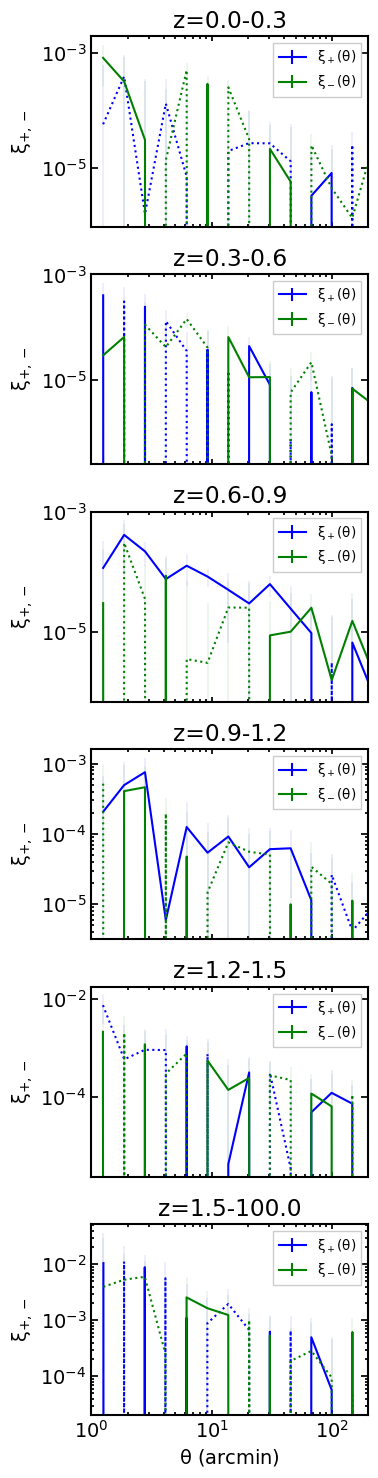

In [20]:
plot_gg(df_imag_masked, pz_labels[:6], [4, 15])

Galaxy-galaxy lensing

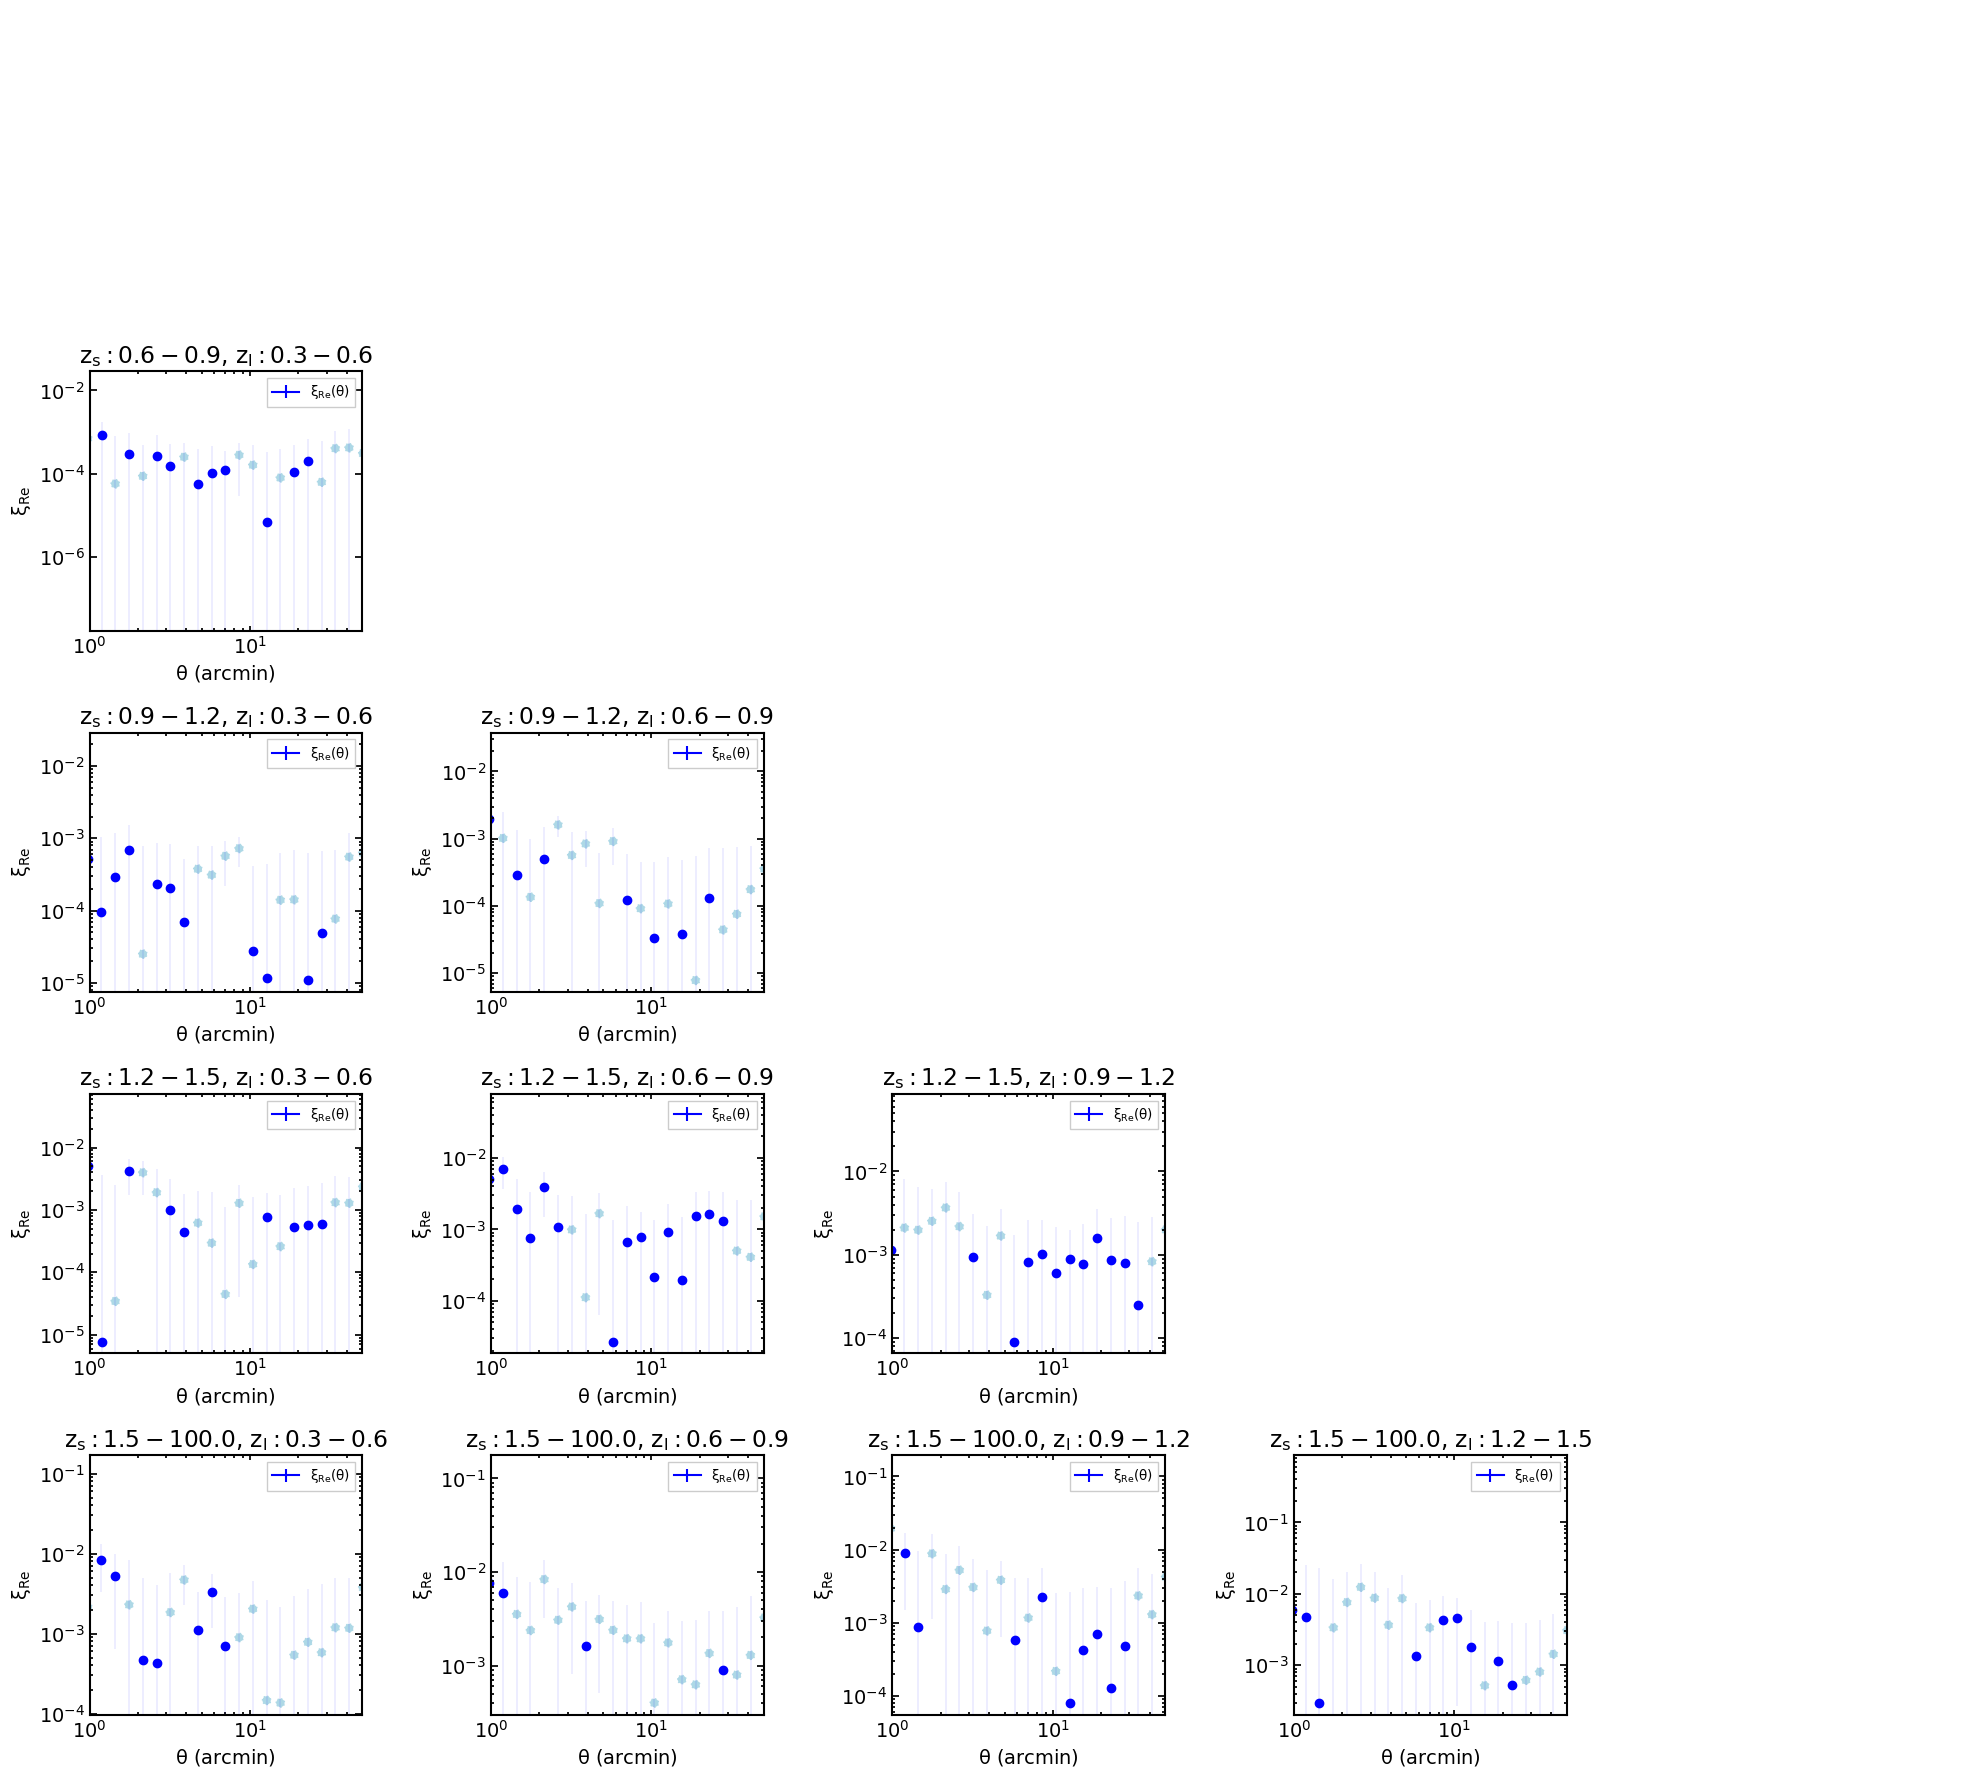

In [21]:
plot_ng(df_imag_masked, pz_labels[1:7], [20, 18])

Clustering in pz and mag bins

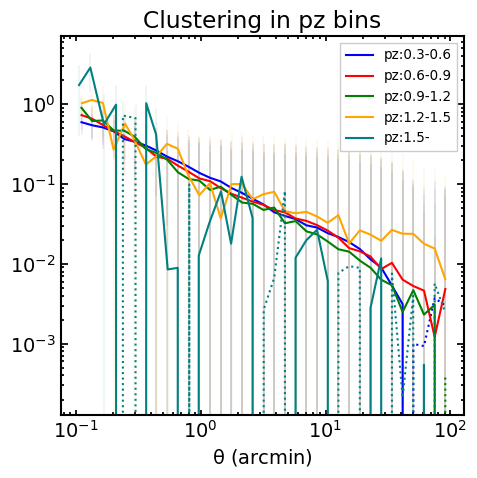

In [19]:
plot_dr(df_imag_masked, rand_df, pz_labels[1:], [5, 5], 'pz')

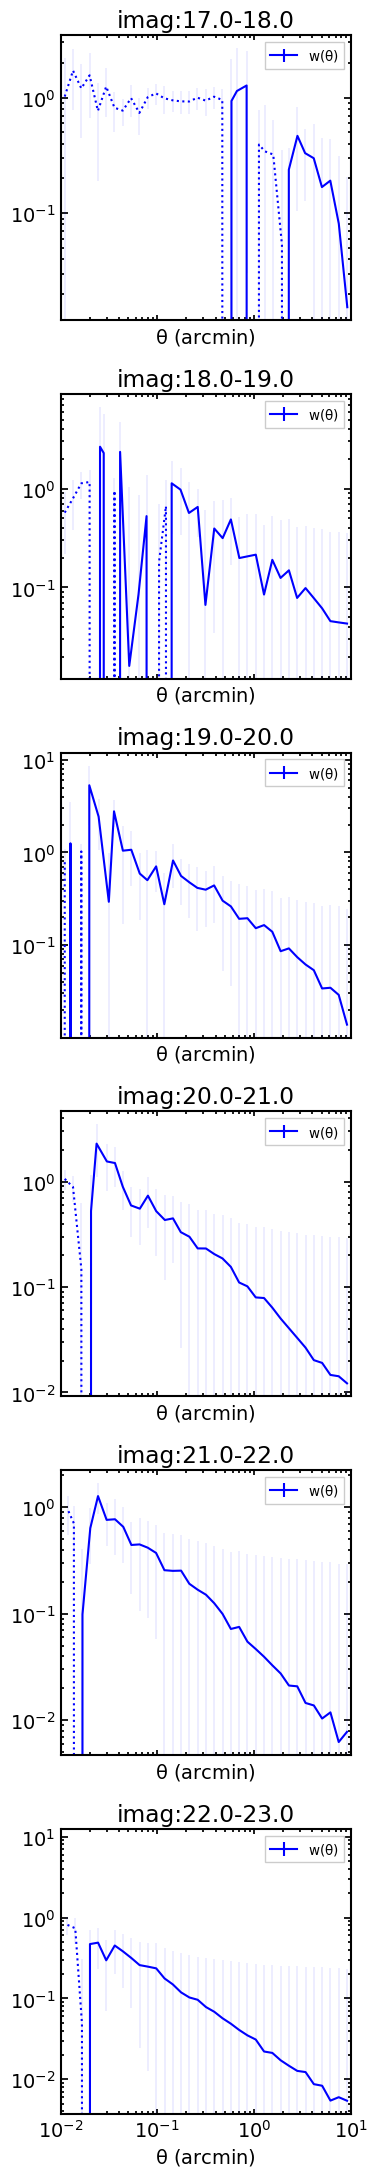

In [22]:
plot_dr(df_imag_masked, rand_df, mag_labels[:6], [4, 22], 'mag')

In [ ]:
dat = df_imag_masked[df_imag_masked.pz_group == '0.0-0.2']